* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial

In [1]:
import os, unicodedata, string, torch, time, random
import torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt, matplotlib.ticker as ticker  

all_chars = string.ascii_letters + " .,;'"
len_chars = len(all_chars)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
                and c in all_chars
    )

print(unicodeToAscii('Ślusàrski'))

# Build the names dictionary, a list of names per language
names = {}
languages = []
for f in os.scandir('data/names'):
    with open(f.path, 'r', encoding='utf-8') as fr:
        language = os.path.splitext(f.name)[0]
        languages.append(language)
        names[language] = [unicodeToAscii(line) for line in fr.readlines()]

print(languages, len_chars, len(names))

Slusarski
['French', 'Russian', 'Korean', 'Dutch', 'Czech', 'Japanese', 'Arabic', 'Scottish', 'Greek', 'Spanish', 'German', 'Italian', 'Irish', 'English', 'Chinese', 'Portuguese', 'Vietnamese', 'Polish'] 57 18


In [2]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_chars.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, len_chars)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(word): 
    return torch.stack([letterToTensor(letter) for letter in word])

print(letterToTensor('J'), nameToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]]) torch.Size([5, 1, 57])


In [3]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    language = randomChoice(languages)                # Chinese
    name     = randomChoice(names[language])  # Xiu'E 秀娥
    y = torch.tensor([languages.index(language)], dtype=torch.long)
    x = nameToTensor(name)
    return language, name, y, x

for i in range(10):
    language, name, y, x = randomTrainingExample()
    print(f'language:{language:<11}/ name:{name:<12}')
    
print(y, x)

language:Arabic     / name:Gerges      
language:Czech      / name:Cervenka    
language:French     / name:Michel      
language:Spanish    / name:Villa       
language:Dutch      / name:Reinder     
language:Czech      / name:Wondracek   
language:Greek      / name:Kosmas      
language:German     / name:Messmann    
language:Korean     / name:Ahn         
language:Irish      / name:O'Hare      
tensor([12]) tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__() 
        self.hidden_size = hidden_size 
        self.W1 = nn.Linear(input_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.W3 = nn.Linear(hidden_size, output_size)
        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        h = F.tanh(self.W1(x) + self.W2(h))
        y = self.sm(self.W3(h))
        return y, h

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(len_chars, n_hidden, len(languages))

In [5]:
# A test run
x = nameToTensor('Albert')
h = torch.zeros(1, n_hidden)

y, h = rnn(x[0], h)
print(y)

tensor([[-2.9858, -2.8603, -2.9844, -2.7690, -2.8334, -2.8072, -2.7563, -2.8666,
         -2.8100, -2.9550, -2.9747, -2.7279, -3.0382, -2.9747, -2.8798, -3.0215,
         -2.9843, -2.8786]], grad_fn=<LogSoftmaxBackward0>)


In [6]:
def y2language(y):
    top, i = y.topk(1)
    i = i[0][0].item() 
    return languages[i], i

print(y2language(y))

('Italian', 11)


     0 lapse:  0 m  0 s, loss:2.7684, feature:Notoriano, label:Italian, guess:Dutch, ✗
  5000 lapse:  0 m  5 s, loss:2.9977, feature:Garcia, label:Portuguese, guess:Japanese, ✗
 10000 lapse:  0 m 10 s, loss:4.0195, feature:Rutberg, label:Russian, guess:German, ✗
 15000 lapse:  0 m 16 s, loss:2.4706, feature:Mullen, label:Irish, guess:German, ✗
 20000 lapse:  0 m 21 s, loss:1.8388, feature:Gil, label:Korean, guess:Chinese, ✗
 25000 lapse:  0 m 27 s, loss:0.8659, feature:Vourlis, label:Greek, guess:Greek, ✓
 30000 lapse:  0 m 32 s, loss:0.7241, feature:Vieth, label:German, guess:German, ✓
 35000 lapse:  0 m 37 s, loss:0.6342, feature:Ganim, label:Arabic, guess:Arabic, ✓
 40000 lapse:  0 m 43 s, loss:1.4133, feature:Kastner, label:German, guess:Arabic, ✗
 45000 lapse:  0 m 48 s, loss:0.2417, feature:Varvitsiotes, label:Greek, guess:Greek, ✓
 50000 lapse:  0 m 54 s, loss:3.7957, feature:Desrosiers, label:French, guess:Portuguese, ✗
 55000 lapse:  0 m 59 s, loss:1.0475, feature:Matsuki, lab

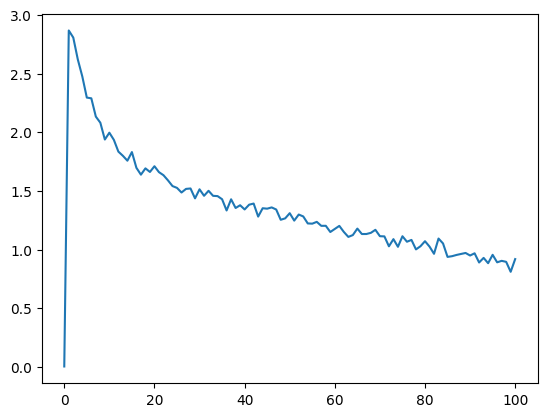

In [7]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn 
criterion = nn.NLLLoss()
def train(y_label, x_feature):
    h = rnn.initHidden()
    rnn.zero_grad()

    for i in range(x_feature.size()[0]):
        y_predict, h = rnn(x_feature[i], h)

    loss = criterion(y_predict, y_label)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return y_predict, loss.item()

def timeSince(since): 
    s = time.time() - since 
    return f' {int(s // 60):2} m {int(s % 60):2} s'

current_loss = 0
all_losses = []
start = time.time() 
for epoch in range(100001):
    language, name, y_label, x_feature = randomTrainingExample() 
    y_predict, loss = train(y_label, x_feature)
    current_loss += loss

    if epoch % 5000 == 0:
        guess, i = y2language(y_predict)
        correct = '✓' if guess == language else '✗'
        print(f'{epoch:>6} lapse:{timeSince(start)}, loss:{loss:.4f}, feature:{name}, label:{language}, guess:{guess}, {correct}')

    # Add current loss avg to list of losses
    if epoch % 1000 == 0:
        all_losses.append(current_loss / 1000)
        current_loss = 0

plt.plot(all_losses)

In [8]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(languages), len(languages))
n_confusion = 10000

# Just return an output given a line
def evaluate(x_feature):
    h = rnn.initHidden()

    for i in range(x_feature.size()[0]):
        y_predict, h = rnn(x_feature[i], h)

    return y_predict

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    language, name, y_label, x_feature = randomTrainingExample()
    y_predict = evaluate(x_feature)
    guess, i = y2language(y_predict) 
    j = languages.index(language)
    confusion[j][i] += 1

# Normalize by dividing every row by its sum
for i in range(len(languages)):
    confusion[i] = confusion[i] / confusion[i].sum()

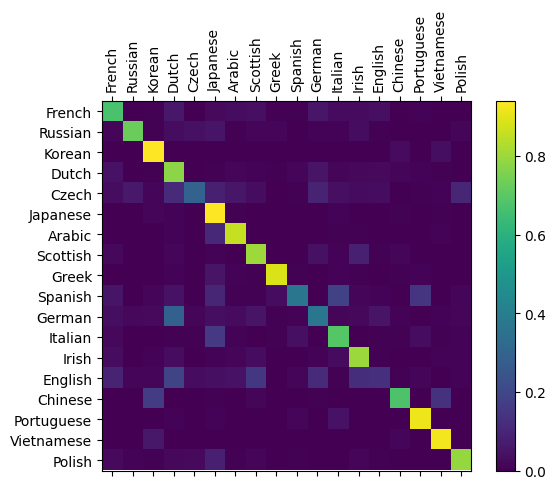

In [9]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks().tolist())) 
ax.yaxis.set_major_locator(ticker.MultipleLocator(1)) 
ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks().tolist())) 

# Add label
ax.set_xticklabels(['']+languages+[''], rotation=90)
ax.set_yticklabels(['']+languages+['']) 
plt.show()